In [43]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from scipy import stats
import sys
from pathlib import Path

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent))

# Configure display and plotting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("📚 Libraries imported successfully!")
print(f"📊 Analysis started at: {pd.Timestamp.now()}")


📚 Libraries imported successfully!
📊 Analysis started at: 2025-10-03 16:21:27.618399


In [44]:
# Load the dataset
try:
    df = pd.read_csv('../data/raw/bengaluru_house_prices.csv')
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ Dataset not found. Creating sample data...")
    # Create sample data for demonstration
    np.random.seed(42)
    sample_locations = ['Whitefield', 'Electronic City', 'Marathahalli', 'BTM Layout', 'Koramangala']
    n_samples = 1000
    
    df = pd.DataFrame({
        'area_type': np.random.choice(['Super built-up Area', 'Built-up Area'], n_samples),
        'availability': np.random.choice(['Ready To Move', '18-Jun'], n_samples, p=[0.8, 0.2]),
        'location': np.random.choice(sample_locations, n_samples),
        'size': [f"{np.random.choice([1,2,3,4])} BHK" for _ in range(n_samples)],
        'society': [f"Society {i}" for i in np.random.randint(1, 50, n_samples)],
        'total_sqft': np.random.normal(1200, 400, n_samples),
        'bath': np.random.randint(1, 5, n_samples),
        'balcony': np.random.randint(0, 4, n_samples),
        'price': np.random.normal(80, 30, n_samples)
    })
    df['total_sqft'] = np.maximum(df['total_sqft'], 500)
    df['price'] = np.maximum(df['price'], 20)
    print("📊 Sample dataset created for demonstration")

print(f"\n📋 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Columns: {list(df.columns)}")


✅ Dataset loaded successfully!

📋 Dataset Overview:
Shape: (13320, 9)
Size: 4.66 MB
Columns: ['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 'balcony', 'price']


In [45]:
# Fix data types
print("🔧 Converting data types...")

# Convert to numeric
df['total_sqft'] = pd.to_numeric(df['total_sqft'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['bath'] = pd.to_numeric(df['bath'], errors='coerce')
df['balcony'] = pd.to_numeric(df['balcony'], errors='coerce')

# Handle BHK
if 'bhk' not in df.columns and 'size' in df.columns:
    df['bhk'] = df['size'].str.extract('(\d+)').astype(float)
else:
    df['bhk'] = pd.to_numeric(df['bhk'], errors='coerce')

# Clean data
df = df.dropna(subset=['price', 'total_sqft', 'bhk'])

print(f"✅ Ready for analysis. Shape: {df.shape}")
print("Final data types:")
print(df[['total_sqft', 'price', 'bhk', 'bath', 'balcony']].dtypes)


🔧 Converting data types...
✅ Ready for analysis. Shape: (13065, 10)
Final data types:
total_sqft    float64
price         float64
bhk           float64
bath          float64
balcony       float64
dtype: object


In [46]:
# Display first few rows
print("📖 First 10 rows:")
display(df.head(10))


📖 First 10 rows:


,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07,2.0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600.0,5.0,3.0,120.00,4.0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00,3.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,3.0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00,2.0
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170.0,2.0,1.0,38.00,2.0
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732.0,4.0,NaN,204.00,4.0
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300.0,4.0,NaN,600.00,4.0
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310.0,3.0,1.0,63.25,3.0
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020.0,6.0,NaN,370.00,6.0


In [47]:
# Basic dataset information
print("ℹ️ Dataset Information:")
display(df.info())

print("\n📊 Data Types:")
display(df.dtypes.value_counts())


ℹ️ Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 13065 entries, 0 to 13319
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13065 non-null  object 
 1   availability  13065 non-null  object 
 2   location      13064 non-null  object 
 3   size          13065 non-null  object 
 4   society       7596 non-null   object 
 5   total_sqft    13065 non-null  float64
 6   bath          13057 non-null  float64
 7   balcony       12525 non-null  float64
 8   price         13065 non-null  float64
 9   bhk           13065 non-null  float64
dtypes: float64(5), object(5)
memory usage: 1.1+ MB


None


📊 Data Types:


object     5
float64    5
Name: count, dtype: int64

🔍 Missing Values Analysis:


,Missing Count,Missing Percentage
society,5469,41.859931
balcony,540,4.133180
bath,8,0.061232
location,1,0.007654


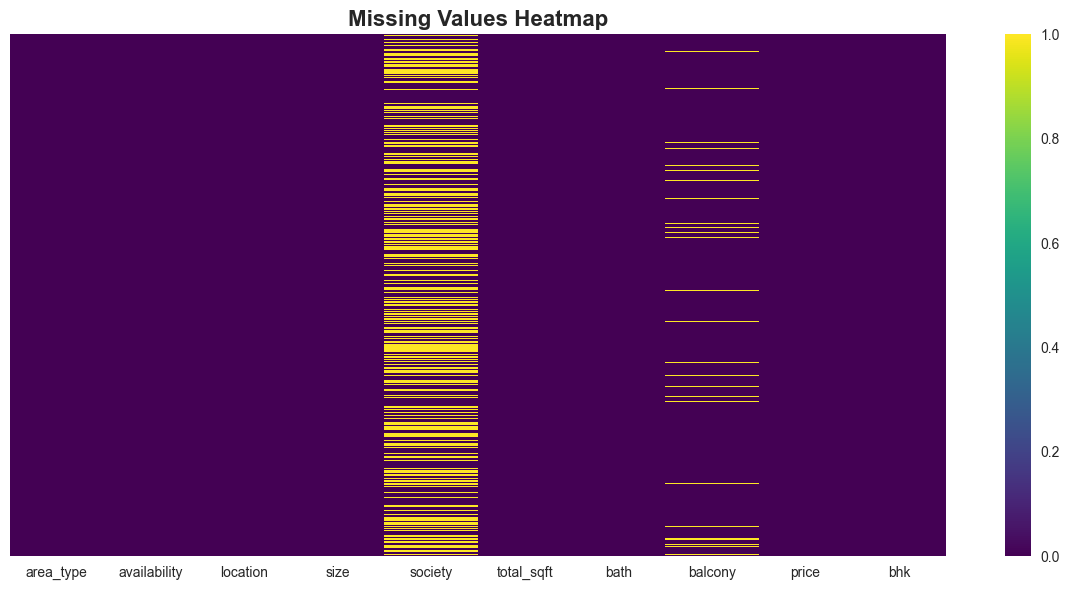

In [48]:
# Missing values analysis
print("🔍 Missing Values Analysis:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

missing_df = missing_df[missing_df['Missing Count'] > 0]
if len(missing_df) > 0:
    display(missing_df.sort_values('Missing Percentage', ascending=False))
    
    # Visualize missing values
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found!")


In [49]:
# Duplicate values analysis
duplicates = df.duplicated().sum()
print(f"🔄 Duplicate Analysis:")
print(f"Total duplicates: {duplicates} ({duplicates/len(df)*100:.2f}%)")

if duplicates > 0:
    print("\nSample duplicate rows:")
    display(df[df.duplicated()].head())


🔄 Duplicate Analysis:
Total duplicates: 528 (4.04%)

Sample duplicate rows:


,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk
971,Super built-up Area,Ready To Move,Haralur Road,3 BHK,NRowse,1464.0,3.0,2.0,56.0,3.0
1115,Super built-up Area,Ready To Move,Haralur Road,2 BHK,NaN,1027.0,2.0,2.0,44.0,2.0
1143,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246.0,2.0,1.0,64.5,2.0
1290,Super built-up Area,Ready To Move,Haralur Road,2 BHK,NaN,1194.0,2.0,2.0,47.0,2.0
1394,Super built-up Area,Ready To Move,Haralur Road,2 BHK,NaN,1027.0,2.0,2.0,44.0,2.0


In [50]:
# Descriptive statistics
print("📊 Descriptive Statistics:")
display(df.describe(include='all').round(2))


📊 Descriptive Statistics:


,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk
count,13065,13065,13064,13065,7596,13065.00,13057.00,12525.0,13065.00,13065.00
unique,4,80,1298,31,2637,NaN,NaN,NaN,NaN,NaN
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,NaN,NaN,NaN,NaN,NaN
freq,8602,10484,517,5148,80,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1554.55,2.69,1.6,112.51,2.81
std,NaN,NaN,NaN,NaN,NaN,1238.42,1.34,0.8,149.66,1.29
min,NaN,NaN,NaN,NaN,NaN,1.00,1.00,0.0,8.00,1.00
25%,NaN,NaN,NaN,NaN,NaN,1100.00,2.00,1.0,50.00,2.00
50%,NaN,NaN,NaN,NaN,NaN,1275.00,2.00,2.0,72.00,3.00
75%,NaN,NaN,NaN,NaN,NaN,1670.00,3.00,2.0,120.00,3.00


In [51]:
# Price distribution analysis
print("💰 Price Analysis:")
print(f"Mean price: ₹{df['price'].mean():.2f} lakhs")
print(f"Median price: ₹{df['price'].median():.2f} lakhs")
print(f"Standard deviation: ₹{df['price'].std():.2f} lakhs")
print(f"Price range: ₹{df['price'].min():.2f} - ₹{df['price'].max():.2f} lakhs")
print(f"Coefficient of variation: {(df['price'].std()/df['price'].mean())*100:.1f}%")

# Price percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
price_percentiles = df['price'].quantile([p/100 for p in percentiles])
print(f"\n📈 Price Percentiles:")
for i, p in enumerate(percentiles):
    print(f"{p}th percentile: ₹{price_percentiles.iloc[i]:.2f} lakhs")


💰 Price Analysis:
Mean price: ₹112.51 lakhs
Median price: ₹72.00 lakhs
Standard deviation: ₹149.66 lakhs
Price range: ₹8.00 - ₹3600.00 lakhs
Coefficient of variation: 133.0%

📈 Price Percentiles:
10th percentile: ₹38.00 lakhs
25th percentile: ₹50.00 lakhs
50th percentile: ₹72.00 lakhs
75th percentile: ₹120.00 lakhs
90th percentile: ₹220.00 lakhs
95th percentile: ₹320.00 lakhs
99th percentile: ₹660.00 lakhs


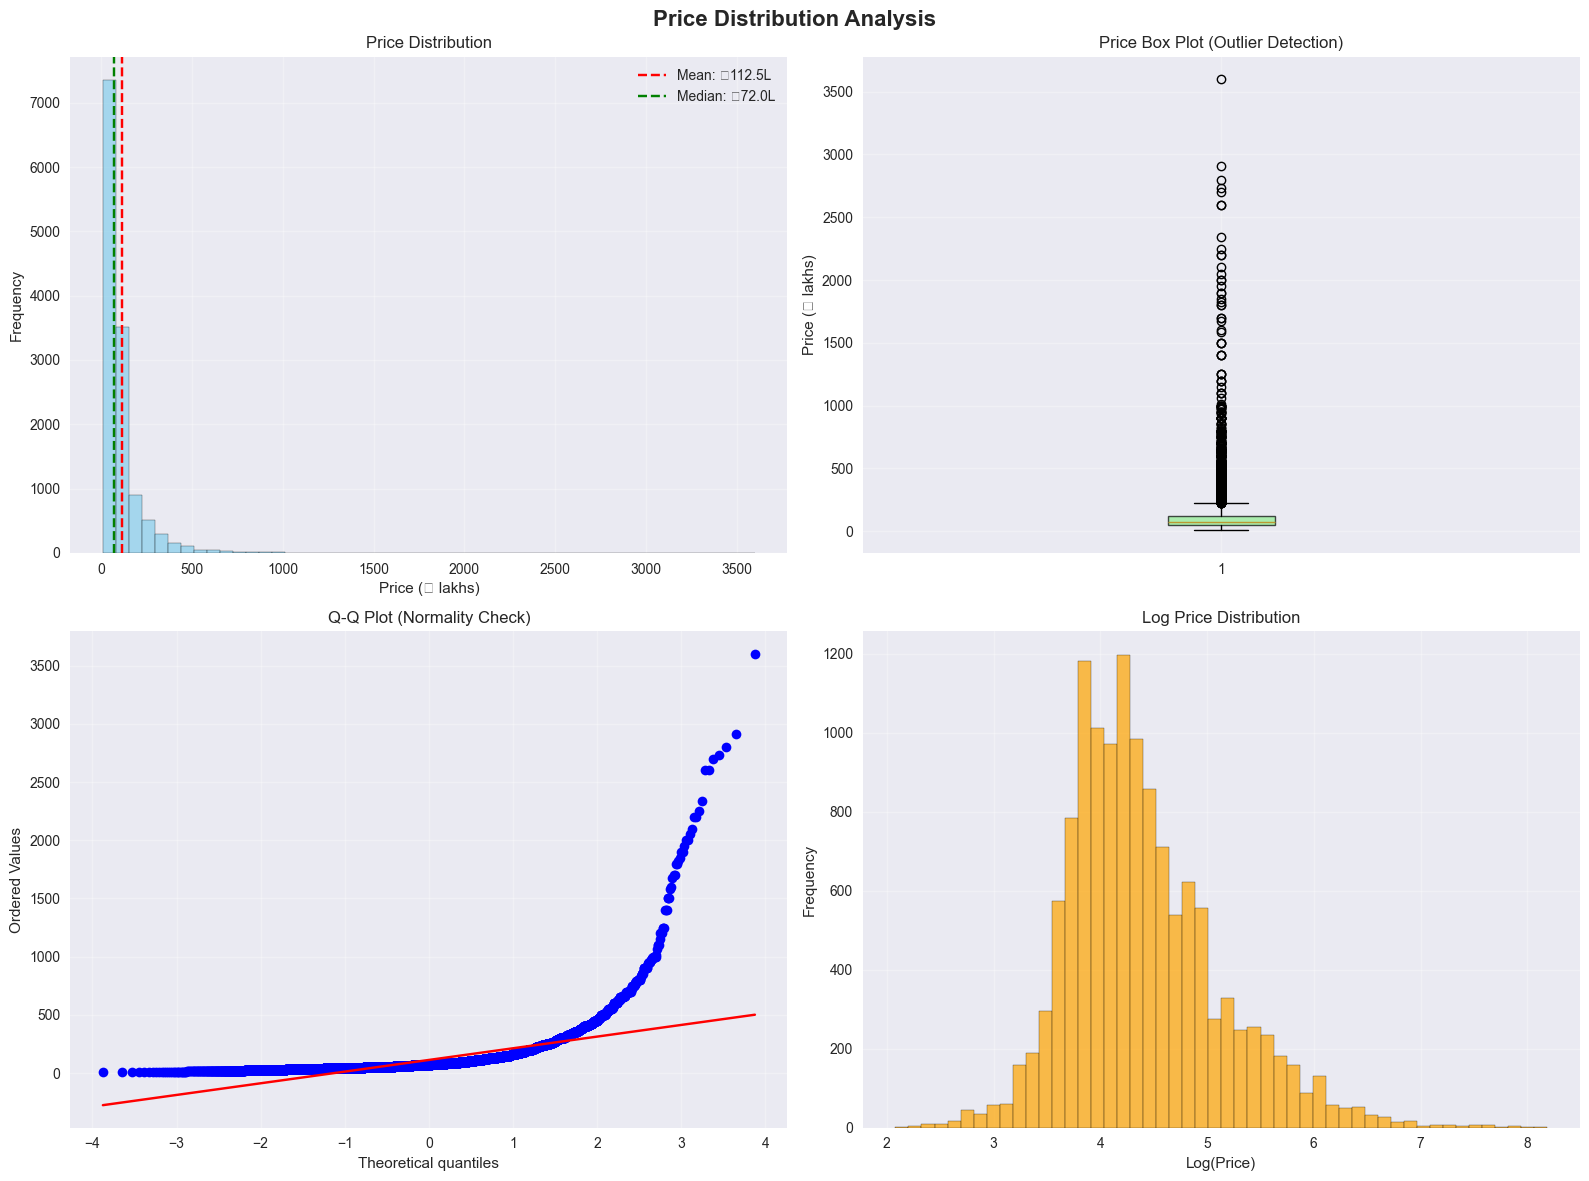


📊 Distribution Shape:
Skewness: 8.096 (Right-skewed)
Kurtosis: 108.239 (Heavy-tailed)


In [52]:
# Price distribution visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Price Distribution Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0, 0].hist(df['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: ₹{df["price"].mean():.1f}L')
axes[0, 0].axvline(df['price'].median(), color='green', linestyle='--', label=f'Median: ₹{df["price"].median():.1f}L')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price (₹ lakhs)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['price'], vert=True, patch_artist=True, 
                   boxprops=dict(facecolor='lightgreen', alpha=0.7))
axes[0, 1].set_title('Price Box Plot (Outlier Detection)')
axes[0, 1].set_ylabel('Price (₹ lakhs)')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(df['price'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')
axes[1, 0].grid(True, alpha=0.3)

# Log price distribution
log_prices = np.log(df['price'])
axes[1, 1].hist(log_prices, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Log Price Distribution')
axes[1, 1].set_xlabel('Log(Price)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Skewness and kurtosis
print(f"\n📊 Distribution Shape:")
print(f"Skewness: {df['price'].skew():.3f} ({'Right-skewed' if df['price'].skew() > 0 else 'Left-skewed'})")
print(f"Kurtosis: {df['price'].kurtosis():.3f} ({'Heavy-tailed' if df['price'].kurtosis() > 0 else 'Light-tailed'})")


📊 Column Types:
Categorical columns (5): ['area_type', 'availability', 'location', 'size', 'society']
Numerical columns (5): ['total_sqft', 'bath', 'balcony', 'price', 'bhk']

📋 Analysis of 'area_type':
Unique values: 4
Most frequent: Super built-up  Area (8602 occurrences)

Top 10 values:


area_type
Super built-up  Area    8602
Built-up  Area          2391
Plot  Area              1991
Carpet  Area              81
Name: count, dtype: int64

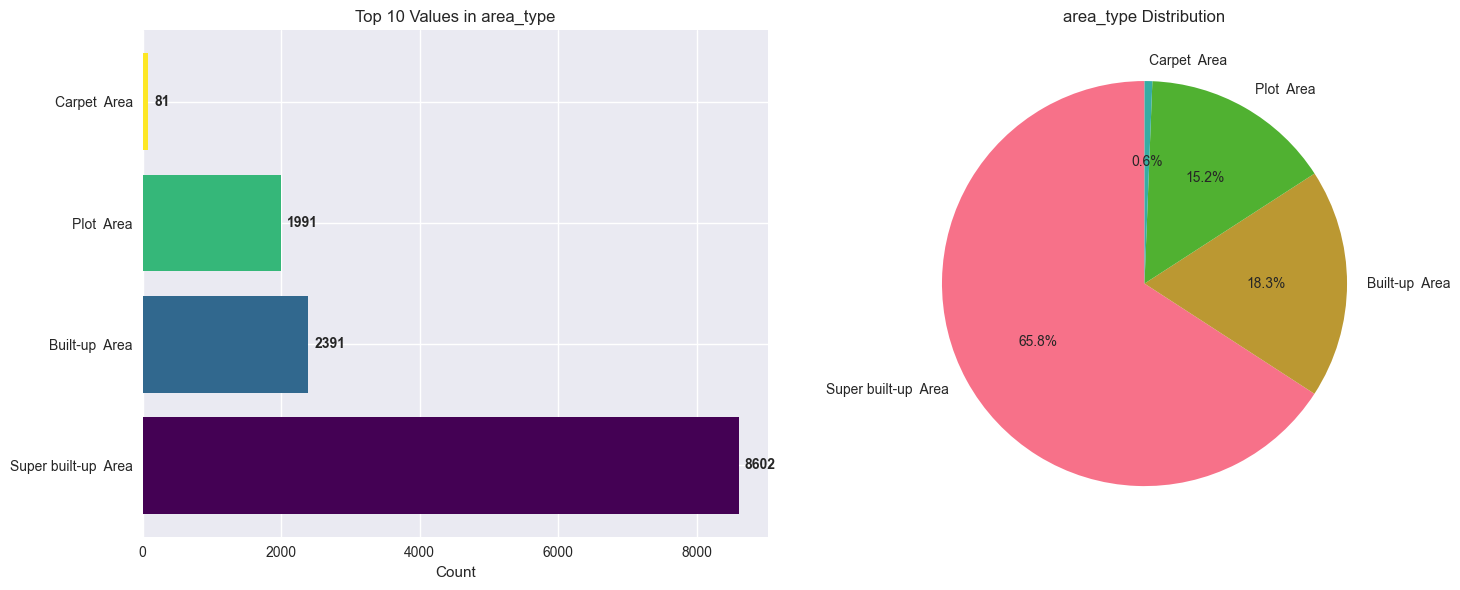


📋 Analysis of 'availability':
Unique values: 80
Most frequent: Ready To Move (10484 occurrences)

Top 10 values:


availability
Ready To Move    10484
18-Dec             287
18-May             284
18-Apr             268
18-Aug             197
19-Dec             170
18-Jul             142
18-Mar             118
18-Jun              92
21-Dec              90
Name: count, dtype: int64

⚠️ Too many unique values (80) to visualize effectively

📋 Analysis of 'location':
Unique values: 1298
Most frequent: Whitefield (517 occurrences)

Top 10 values:


location
Whitefield               517
Sarjapur  Road           387
Electronic City          302
Kanakpura Road           264
Thanisandra              222
Yelahanka                203
Uttarahalli              185
Marathahalli             175
Hebbal                   172
Raja Rajeshwari Nagar    171
Name: count, dtype: int64

⚠️ Too many unique values (1298) to visualize effectively

📋 Analysis of 'size':
Unique values: 31
Most frequent: 2 BHK (5148 occurrences)

Top 10 values:


size
2 BHK        5148
3 BHK        4254
4 Bedroom     811
4 BHK         546
3 Bedroom     542
1 BHK         492
2 Bedroom     325
5 Bedroom     294
6 Bedroom     190
1 Bedroom     100
Name: count, dtype: int64

⚠️ Too many unique values (31) to visualize effectively

📋 Analysis of 'society':
Unique values: 2637
Most frequent: GrrvaGr (80 occurrences)

Top 10 values:


society
GrrvaGr    80
PrarePa    71
Sryalan    59
GMown E    56
Prtates    52
Prtanha    51
Bhmesy     50
Prityel    50
Prarkun    49
PrityTr    48
Name: count, dtype: int64

⚠️ Too many unique values (2637) to visualize effectively


In [53]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"📊 Column Types:")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Analyze each categorical variable
for col in categorical_cols:
    print(f"\n📋 Analysis of '{col}':")
    
    value_counts = df[col].value_counts()
    print(f"Unique values: {df[col].nunique()}")
    print(f"Most frequent: {value_counts.index[0]} ({value_counts.iloc[0]} occurrences)")
    
    # Top 10 values
    print("\nTop 10 values:")
    display(value_counts.head(10))
    
    # Visualization
    if df[col].nunique() <= 20:  # Only plot if reasonable number of categories
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Bar plot
        top_values = value_counts.head(10)
        bars = ax1.barh(range(len(top_values)), top_values.values, color=plt.cm.viridis(np.linspace(0, 1, len(top_values))))
        ax1.set_yticks(range(len(top_values)))
        ax1.set_yticklabels(top_values.index)
        ax1.set_title(f'Top 10 Values in {col}')
        ax1.set_xlabel('Count')
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, top_values.values)):
            ax1.text(value + max(top_values.values)*0.01, i, str(value), 
                    ha='left', va='center', fontweight='bold')
        
        # Pie chart for top categories
        top_5 = value_counts.head(5)
        others = value_counts[5:].sum()
        
        if others > 0:
            pie_data = list(top_5.values) + [others]
            pie_labels = list(top_5.index) + ['Others']
        else:
            pie_data = top_5.values
            pie_labels = top_5.index
        
        ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
        ax2.set_title(f'{col} Distribution')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Too many unique values ({df[col].nunique()}) to visualize effectively")


🗺️ Location Analysis:

📊 Top 15 Locations by Average Price:


,Property_Count,Avg_Price,Median_Price,Price_Std,Min_Price,Max_Price,Avg_Sqft,Price_per_Sqft
location,,,,,,,,
Cubbon Road,1,1900.00,1900.0,NaN,1900.0,1900.0,5422.00,35042.419771
Ashok Nagar,2,1486.00,1486.0,2016.67,60.0,2912.0,4512.00,32934.397163
Defence Colony,7,1167.71,365.0,1438.84,125.0,3600.0,4017.14,29068.192794
Yemlur,9,1093.39,1675.0,979.79,55.0,2050.0,5931.22,18434.487340
Church Street,2,1068.00,1068.0,752.36,536.0,1600.0,6960.00,15344.827586
D Souza Layout,1,1015.00,1015.0,NaN,1015.0,1015.0,4634.00,21903.323263
Sadashiva Nagar,10,1011.10,655.0,769.65,400.0,2736.0,4787.20,21120.905749
Sindhi Colony,1,988.00,988.0,NaN,988.0,988.0,5665.84,17437.837990
Srinivas Colony,2,922.00,922.0,29.70,901.0,943.0,3575.00,25790.209790


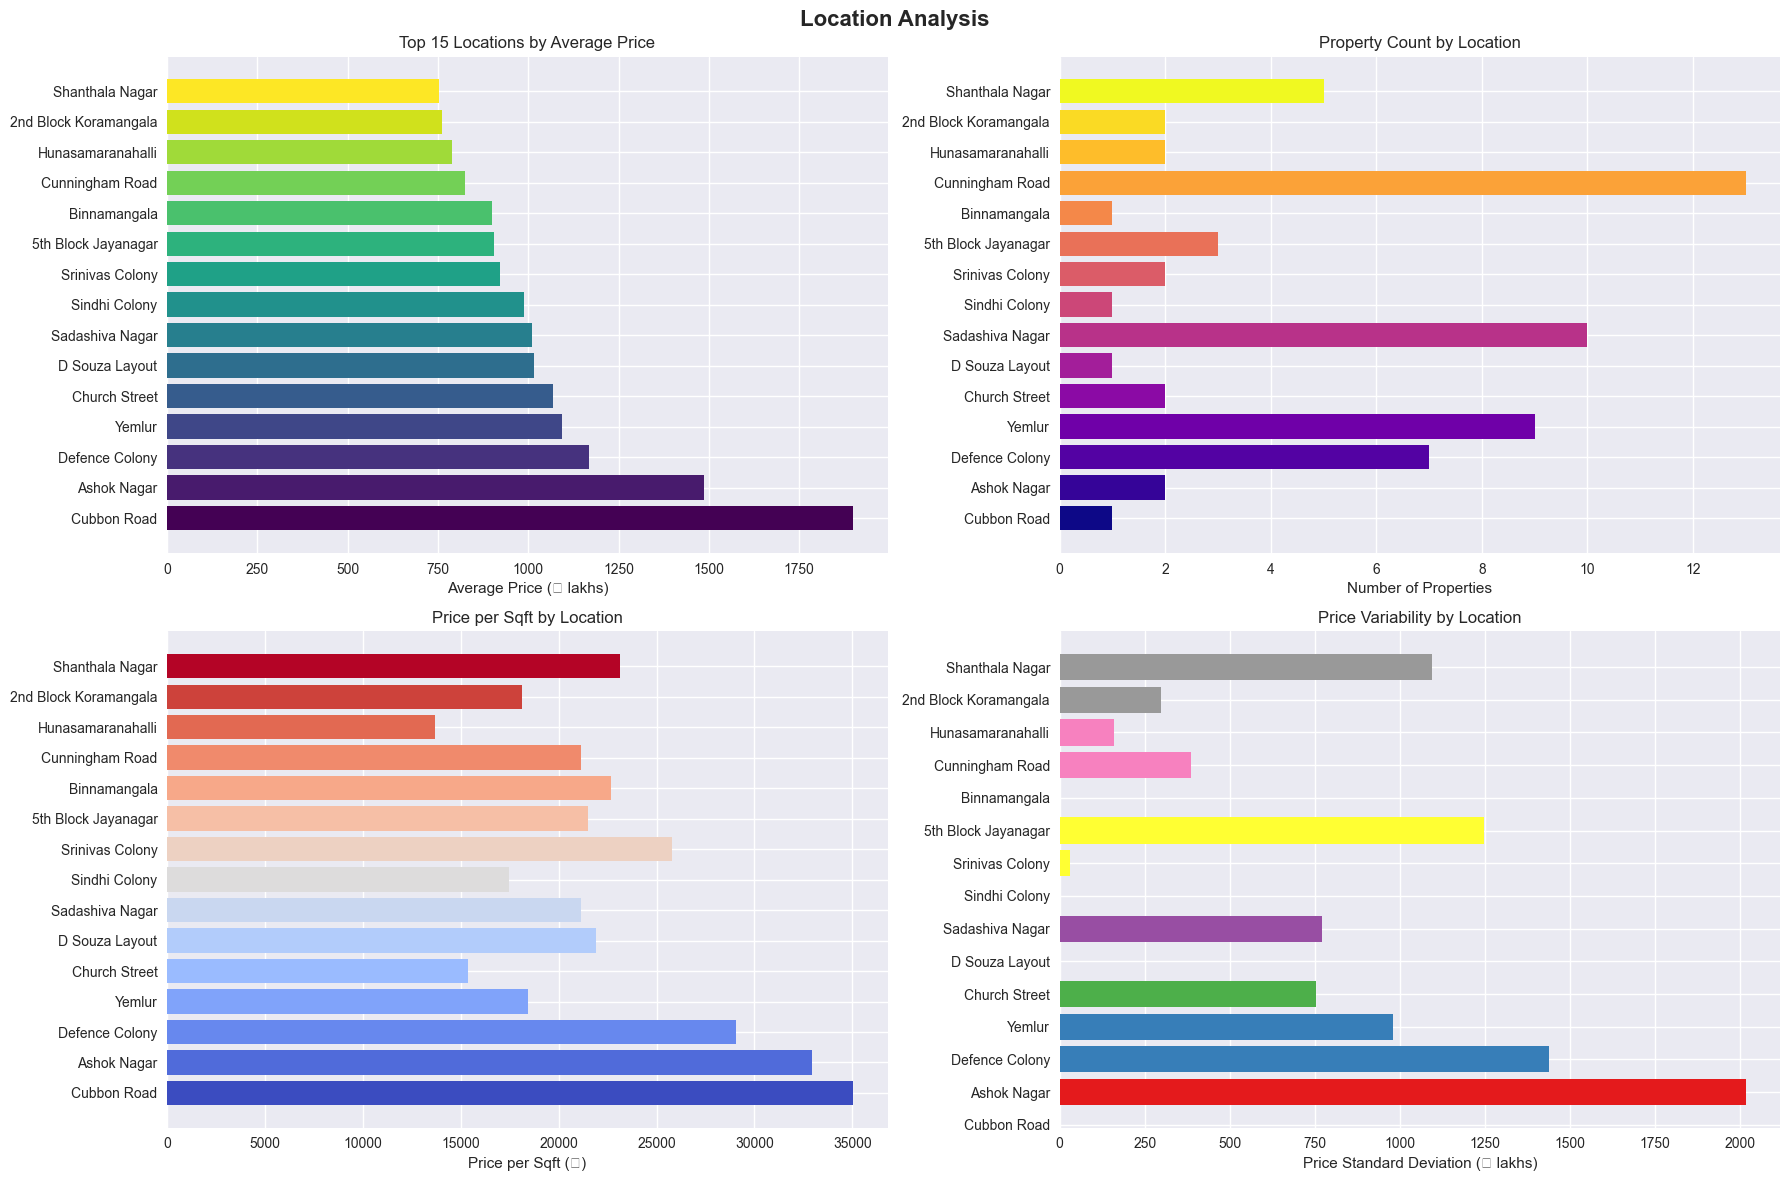

In [54]:
# Detailed location analysis
# Now your location analysis will work
if 'location' in df.columns:
    print("🗺️ Location Analysis:")
    
    # Location statistics - this will now work
    location_stats = df.groupby('location').agg({
        'price': ['count', 'mean', 'median', 'std', 'min', 'max'],
        'total_sqft': 'mean'
    }).round(2)
    
    
    # Flatten column names
    location_stats.columns = ['Property_Count', 'Avg_Price', 'Median_Price', 
                             'Price_Std', 'Min_Price', 'Max_Price', 'Avg_Sqft']
    
    # Calculate price per sqft
    location_stats['Price_per_Sqft'] = (location_stats['Avg_Price'] * 100000) / location_stats['Avg_Sqft']
    
    # Sort by average price
    location_stats = location_stats.sort_values('Avg_Price', ascending=False)
    
    print(f"\n📊 Top 15 Locations by Average Price:")
    display(location_stats.head(15))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Location Analysis', fontsize=16, fontweight='bold')
    
    # Top locations by price
    top_15 = location_stats.head(15)
    axes[0, 0].barh(range(len(top_15)), top_15['Avg_Price'], color=plt.cm.viridis(np.linspace(0, 1, len(top_15))))
    axes[0, 0].set_yticks(range(len(top_15)))
    axes[0, 0].set_yticklabels(top_15.index)
    axes[0, 0].set_title('Top 15 Locations by Average Price')
    axes[0, 0].set_xlabel('Average Price (₹ lakhs)')
    
    # Property count by location
    axes[0, 1].barh(range(len(top_15)), top_15['Property_Count'], color=plt.cm.plasma(np.linspace(0, 1, len(top_15))))
    axes[0, 1].set_yticks(range(len(top_15)))
    axes[0, 1].set_yticklabels(top_15.index)
    axes[0, 1].set_title('Property Count by Location')
    axes[0, 1].set_xlabel('Number of Properties')
    
    # Price per sqft
    axes[1, 0].barh(range(len(top_15)), top_15['Price_per_Sqft'], color=plt.cm.coolwarm(np.linspace(0, 1, len(top_15))))
    axes[1, 0].set_yticks(range(len(top_15)))
    axes[1, 0].set_yticklabels(top_15.index)
    axes[1, 0].set_title('Price per Sqft by Location')
    axes[1, 0].set_xlabel('Price per Sqft (₹)')
    
    # Price variability
    axes[1, 1].barh(range(len(top_15)), top_15['Price_Std'], color=plt.cm.Set1(np.linspace(0, 1, len(top_15))))
    axes[1, 1].set_yticks(range(len(top_15)))
    axes[1, 1].set_yticklabels(top_15.index)
    axes[1, 1].set_title('Price Variability by Location')
    axes[1, 1].set_xlabel('Price Standard Deviation (₹ lakhs)')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No location column found")


🔗 Correlation Analysis:

📊 Correlation Matrix:


,total_sqft,bath,balcony,price,bhk
total_sqft,1.000,0.387,0.155,0.573,0.342
bath,0.387,1.000,0.210,0.454,0.898
balcony,0.155,0.210,1.000,0.121,0.186
price,0.573,0.454,0.121,1.000,0.395
bhk,0.342,0.898,0.186,0.395,1.000


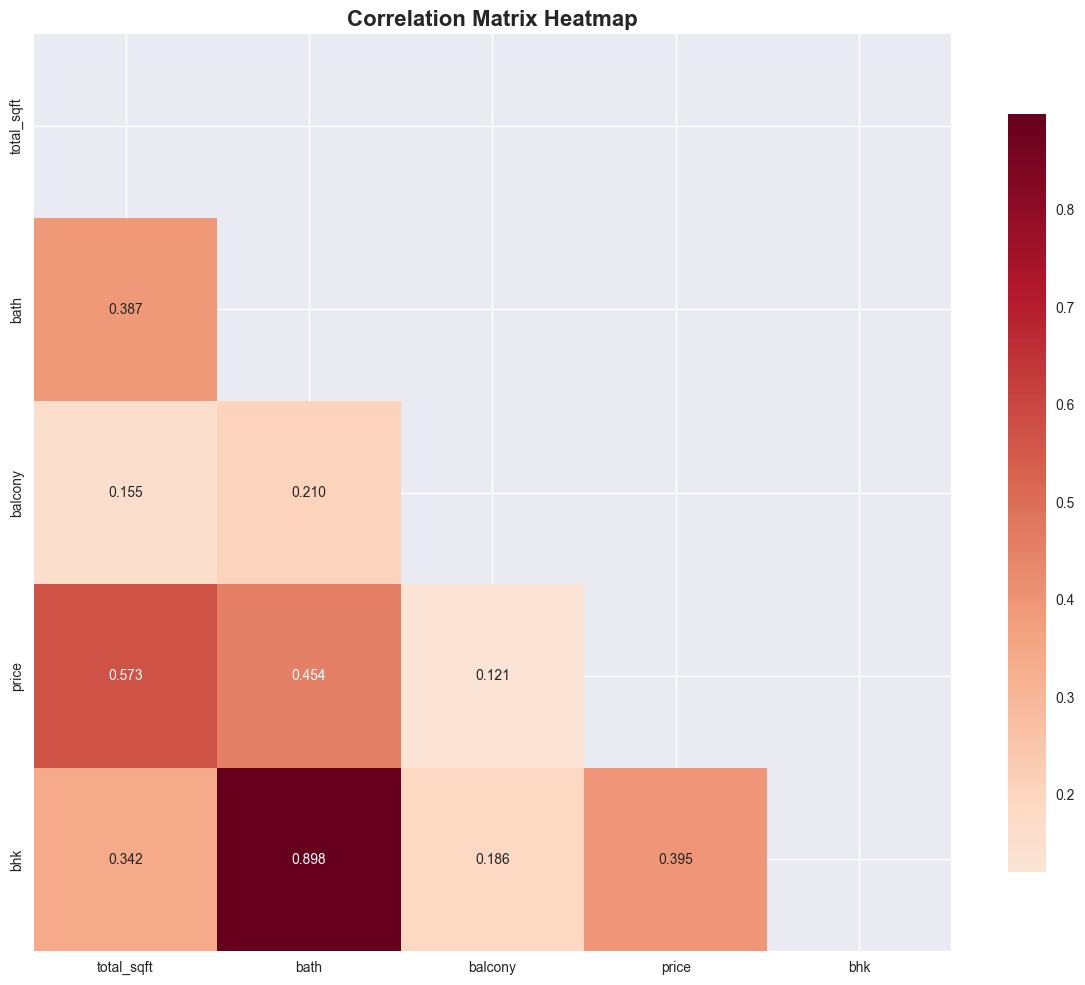


💰 Correlations with Price (sorted by absolute value):
  total_sqft: 0.573 (Moderate Positive)
  bath: 0.454 (Moderate Positive)
  bhk: 0.395 (Weak Positive)
  balcony: 0.121 (Weak Positive)


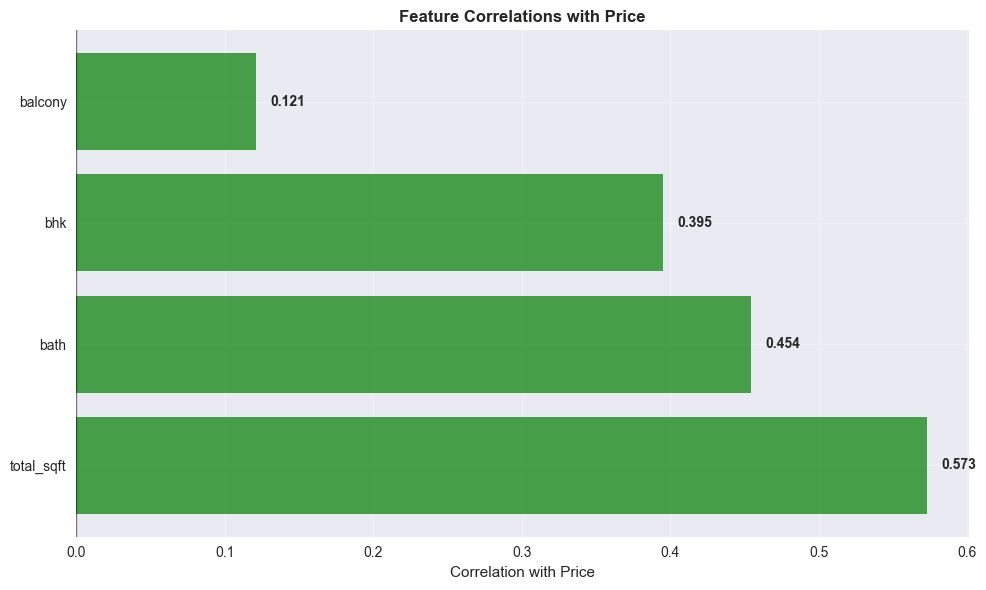

In [55]:
# Correlation analysis
print("🔗 Correlation Analysis:")

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

print("\n📊 Correlation Matrix:")
display(correlation_matrix.round(3))

# Heatmap visualization
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
            center=0, square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Strong correlations with price
if 'price' in numerical_cols:
    price_correlations = correlation_matrix['price'].drop('price').sort_values(key=abs, ascending=False)
    
    print(f"\n💰 Correlations with Price (sorted by absolute value):")
    for feature, corr in price_correlations.items():
        strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"  {feature}: {corr:.3f} ({strength} {direction})")
    
    # Visualize correlations with price
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'green' for x in price_correlations.values]
    bars = plt.barh(range(len(price_correlations)), price_correlations.values, color=colors, alpha=0.7)
    plt.yticks(range(len(price_correlations)), price_correlations.index)
    plt.xlabel('Correlation with Price')
    plt.title('Feature Correlations with Price', fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    # Add correlation values on bars
    for i, (bar, value) in enumerate(zip(bars, price_correlations.values)):
        plt.text(value + 0.01 if value > 0 else value - 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', ha='left' if value > 0 else 'right', va='center', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


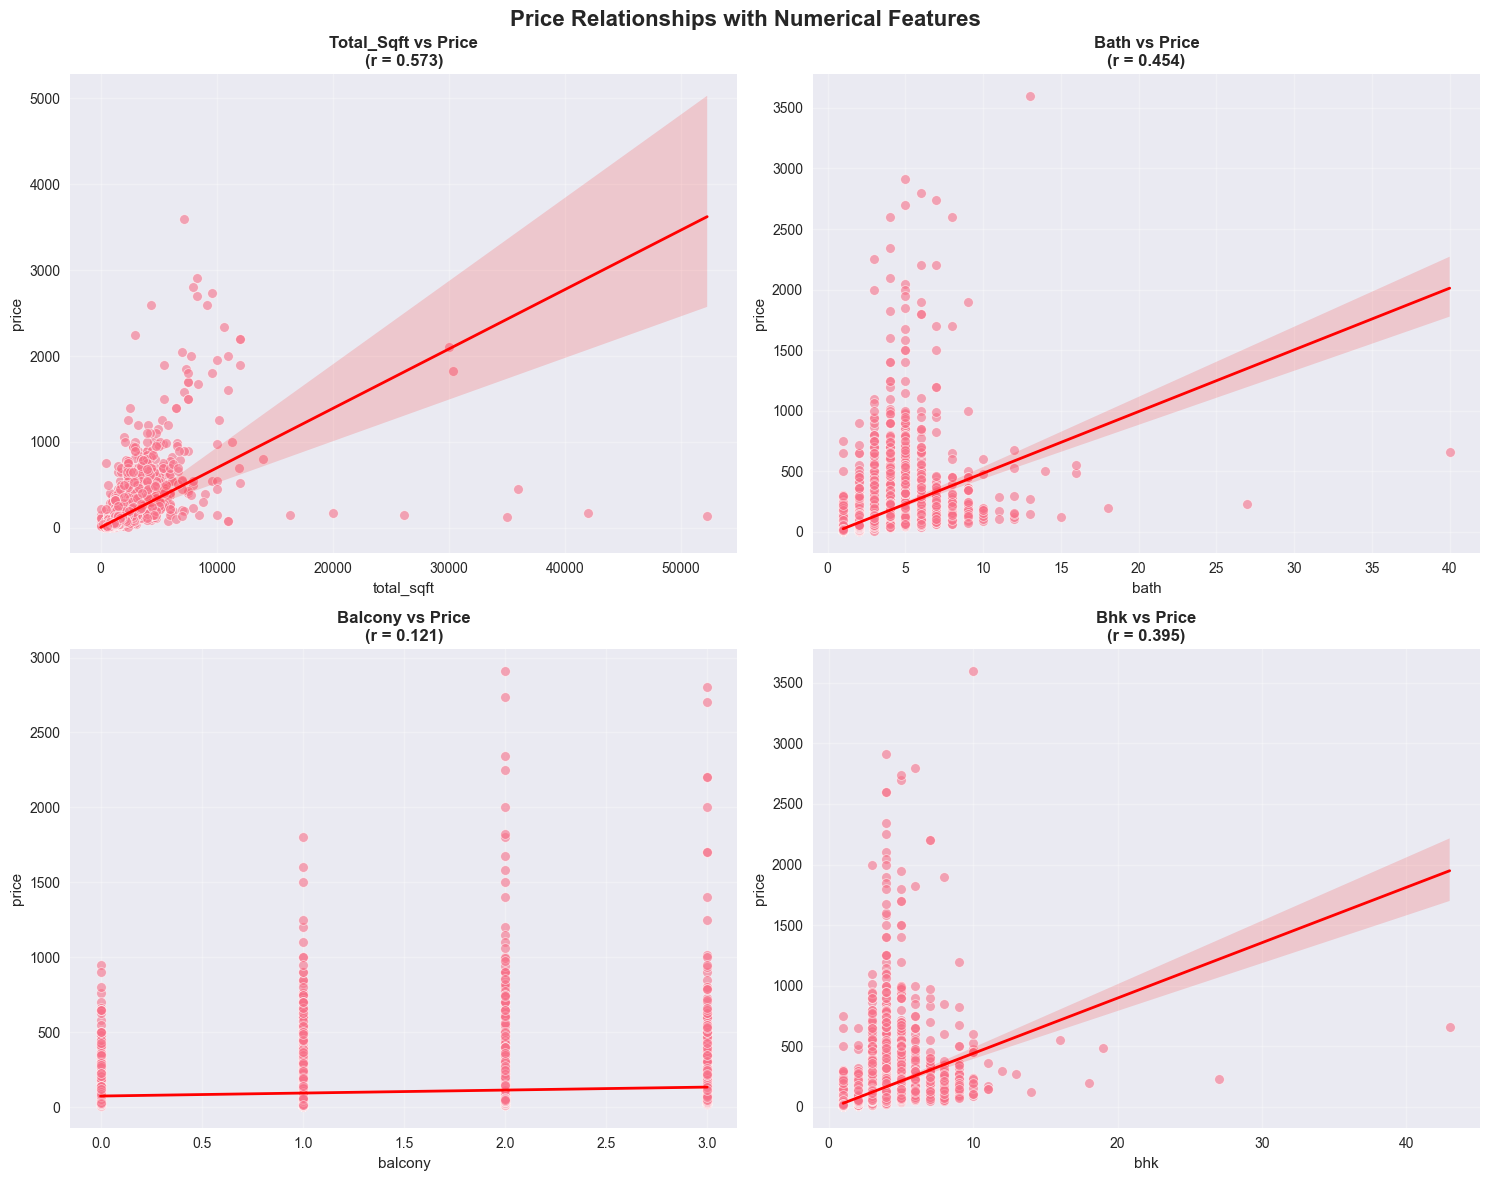

In [56]:
# Scatter plots with price
if 'price' in df.columns:
    numerical_features = [col for col in numerical_cols if col != 'price']
    
    if len(numerical_features) > 0:
        n_features = min(4, len(numerical_features))  # Plot max 4 relationships
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Price Relationships with Numerical Features', fontsize=16, fontweight='bold')
        
        axes = axes.flatten()
        
        for idx, feature in enumerate(numerical_features[:n_features]):
            # Scatter plot with regression line
            sns.scatterplot(data=df, x=feature, y='price', ax=axes[idx], alpha=0.6)
            sns.regplot(data=df, x=feature, y='price', ax=axes[idx], 
                       scatter=False, color='red', line_kws={'linewidth': 2})
            
            # Calculate and display correlation
            corr = df[feature].corr(df['price'])
            axes[idx].set_title(f'{feature.title()} vs Price\n(r = {corr:.3f})', fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
        
        # Remove empty subplots
        for idx in range(n_features, 4):
            fig.delaxes(axes[idx])
        
        plt.tight_layout()
        plt.show()


In [57]:
# Outlier detection using IQR method
def detect_outliers_iqr(series, multiplier=1.5):
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(series, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(series))
    outliers = series[z_scores > threshold]
    return outliers

print("🎯 Outlier Detection Analysis:")

outlier_summary = []

for col in numerical_cols:
    print(f"\n📊 Outlier analysis for {col.title()}:")
    
    # IQR method
    iqr_outliers, lower_bound, upper_bound = detect_outliers_iqr(df[col])
    
    # Z-score method
    zscore_outliers = detect_outliers_zscore(df[col])
    
    print(f"  IQR Method:")
    print(f"    Valid range: {lower_bound:.2f} to {upper_bound:.2f}")
    print(f"    Outliers: {len(iqr_outliers)} ({len(iqr_outliers)/len(df)*100:.1f}%)")
    
    print(f"  Z-score Method (threshold=3):")
    print(f"    Outliers: {len(zscore_outliers)} ({len(zscore_outliers)/len(df)*100:.1f}%)")
    
    outlier_summary.append({
        'Feature': col,
        'IQR_Outliers': len(iqr_outliers),
        'IQR_Percentage': len(iqr_outliers)/len(df)*100,
        'ZScore_Outliers': len(zscore_outliers),
        'ZScore_Percentage': len(zscore_outliers)/len(df)*100,
    })

# Outlier summary table
outlier_df = pd.DataFrame(outlier_summary)
print("\n📋 Outlier Summary:")
display(outlier_df.round(2))


🎯 Outlier Detection Analysis:

📊 Outlier analysis for Total_Sqft:
  IQR Method:
    Valid range: 245.00 to 2525.00
    Outliers: 1122 (8.6%)
  Z-score Method (threshold=3):
    Outliers: 115 (0.9%)

📊 Outlier analysis for Bath:
  IQR Method:
    Valid range: 0.50 to 4.50
    Outliers: 1007 (7.7%)
  Z-score Method (threshold=3):
    Outliers: 0 (0.0%)

📊 Outlier analysis for Balcony:
  IQR Method:
    Valid range: -0.50 to 3.50
    Outliers: 0 (0.0%)
  Z-score Method (threshold=3):
    Outliers: 0 (0.0%)

📊 Outlier analysis for Price:
  IQR Method:
    Valid range: -55.00 to 225.00
    Outliers: 1238 (9.5%)
  Z-score Method (threshold=3):
    Outliers: 188 (1.4%)

📊 Outlier analysis for Bhk:
  IQR Method:
    Valid range: 0.50 to 4.50
    Outliers: 835 (6.4%)
  Z-score Method (threshold=3):
    Outliers: 266 (2.0%)

📋 Outlier Summary:


,Feature,IQR_Outliers,IQR_Percentage,ZScore_Outliers,ZScore_Percentage
0,total_sqft,1122,8.59,115,0.88
1,bath,1007,7.71,0,0.00
2,balcony,0,0.00,0,0.00
3,price,1238,9.48,188,1.44
4,bhk,835,6.39,266,2.04


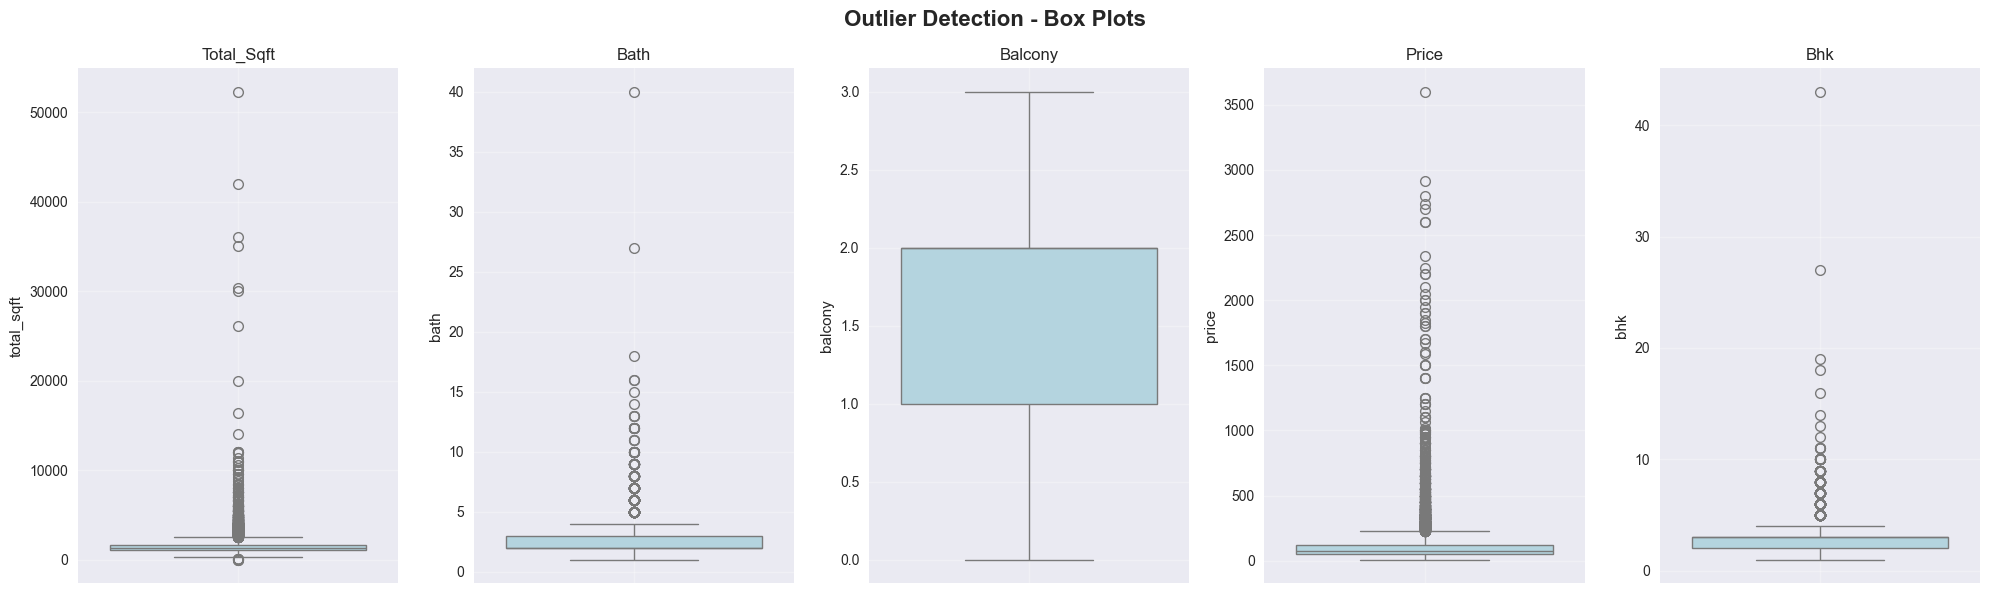

In [58]:
# Visualize outliers
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(4*len(numerical_cols), 6))
fig.suptitle('Outlier Detection - Box Plots', fontsize=16, fontweight='bold')

if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[idx], color='lightblue')
    axes[idx].set_title(f'{col.title()}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [59]:
# Generate comprehensive insights
print("💡 KEY INSIGHTS AND RECOMMENDATIONS")
print("="*60)

insights = []

# Dataset overview insights
insights.append("📊 DATASET OVERVIEW:")
insights.append(f"   • Dataset size: {len(df):,} records with {len(df.columns)} features")
insights.append(f"   • Data completeness: {(1 - df.isnull().sum().sum() / (len(df) * len(df.columns)))*100:.1f}%")
insights.append(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Price insights
if 'price' in df.columns:
    insights.append("\n💰 PRICE INSIGHTS:")
    insights.append(f"   • Average house price: ₹{df['price'].mean():.2f} lakhs")
    insights.append(f"   • Price range: ₹{df['price'].min():.2f} - ₹{df['price'].max():.2f} lakhs")
    insights.append(f"   • Price variability: {(df['price'].std()/df['price'].mean())*100:.1f}% (CV)")
    insights.append(f"   • Distribution: {'Right-skewed' if df['price'].skew() > 0.5 else 'Nearly normal'}")

# Location insights
if 'location' in df.columns:
    insights.append("\n🗺️ LOCATION INSIGHTS:")
    insights.append(f"   • Total locations covered: {df['location'].nunique()}")
    
    top_location = df['location'].value_counts().index[0]
    top_count = df['location'].value_counts().iloc[0]
    insights.append(f"   • Most represented: {top_location} ({top_count} properties)")
    
    if 'price' in df.columns:
        location_prices = df.groupby('location')['price'].mean().sort_values(ascending=False)
        most_expensive = location_prices.index[0]
        least_expensive = location_prices.index[-1]
        insights.append(f"   • Most expensive: {most_expensive} (₹{location_prices.iloc[0]:.2f}L avg)")
        insights.append(f"   • Most affordable: {least_expensive} (₹{location_prices.iloc[-1]:.2f}L avg)")

# Data quality insights
total_outliers = sum([len(detect_outliers_iqr(df[col])[0]) for col in numerical_cols])
outlier_rate = (total_outliers / (len(df) * len(numerical_cols))) * 100

insights.append("\n🎯 DATA QUALITY:")
insights.append(f"   • Overall outlier rate: {outlier_rate:.1f}%")
insights.append(f"   • Duplicate records: {df.duplicated().sum()} ({df.duplicated().sum()/len(df)*100:.1f}%)")
insights.append(f"   • Missing values: {df.isnull().sum().sum()} total")

# Recommendations
insights.append("\n🔧 PREPROCESSING RECOMMENDATIONS:")
if df['price'].skew() > 1:
    insights.append("   • Apply log transformation to price for normality")
if outlier_rate > 5:
    insights.append("   • Implement outlier removal or capping strategy")
if 'location' in df.columns and df['location'].nunique() > 10:
    insights.append("   • Use label encoding or target encoding for location")
insights.append("   • Create derived features (price per sqft, room ratios)")
insights.append("   • Consider feature scaling for distance-based algorithms")

# Print all insights
for insight in insights:
    print(insight)

print(f"\n✅ Analysis completed at: {pd.Timestamp.now()}")
print("🚀 Ready for feature engineering and model development!")


💡 KEY INSIGHTS AND RECOMMENDATIONS
📊 DATASET OVERVIEW:
   • Dataset size: 13,065 records with 10 features
   • Data completeness: 95.4%
   • Memory usage: 4.2 MB

💰 PRICE INSIGHTS:
   • Average house price: ₹112.51 lakhs
   • Price range: ₹8.00 - ₹3600.00 lakhs
   • Price variability: 133.0% (CV)
   • Distribution: Right-skewed

🗺️ LOCATION INSIGHTS:
   • Total locations covered: 1298
   • Most represented: Whitefield (517 properties)
   • Most expensive: Cubbon Road (₹1900.00L avg)
   • Most affordable: Alur (₹15.00L avg)

🎯 DATA QUALITY:
   • Overall outlier rate: 6.4%
   • Duplicate records: 528 (4.0%)
   • Missing values: 6018 total

🔧 PREPROCESSING RECOMMENDATIONS:
   • Apply log transformation to price for normality
   • Implement outlier removal or capping strategy
   • Use label encoding or target encoding for location
   • Create derived features (price per sqft, room ratios)
   • Consider feature scaling for distance-based algorithms

✅ Analysis completed at: 2025-10-03 16:21